In [26]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import utils

In [27]:
data = collections.defaultdict(dict)
for key in [
  'general-ai-4',
]:
  print("Loading", key)
  if isinstance(key, str):
    key, name = key, key
  else:
    key, name = key
  keys, history = utils.load_pickle(f"/Users/kevinclark/Programming/skyteam/data/{key}/history.pkl")
  data[name] = {k: [h[i] for h in history] for i, k in enumerate(keys)}

Loading general-ai-4


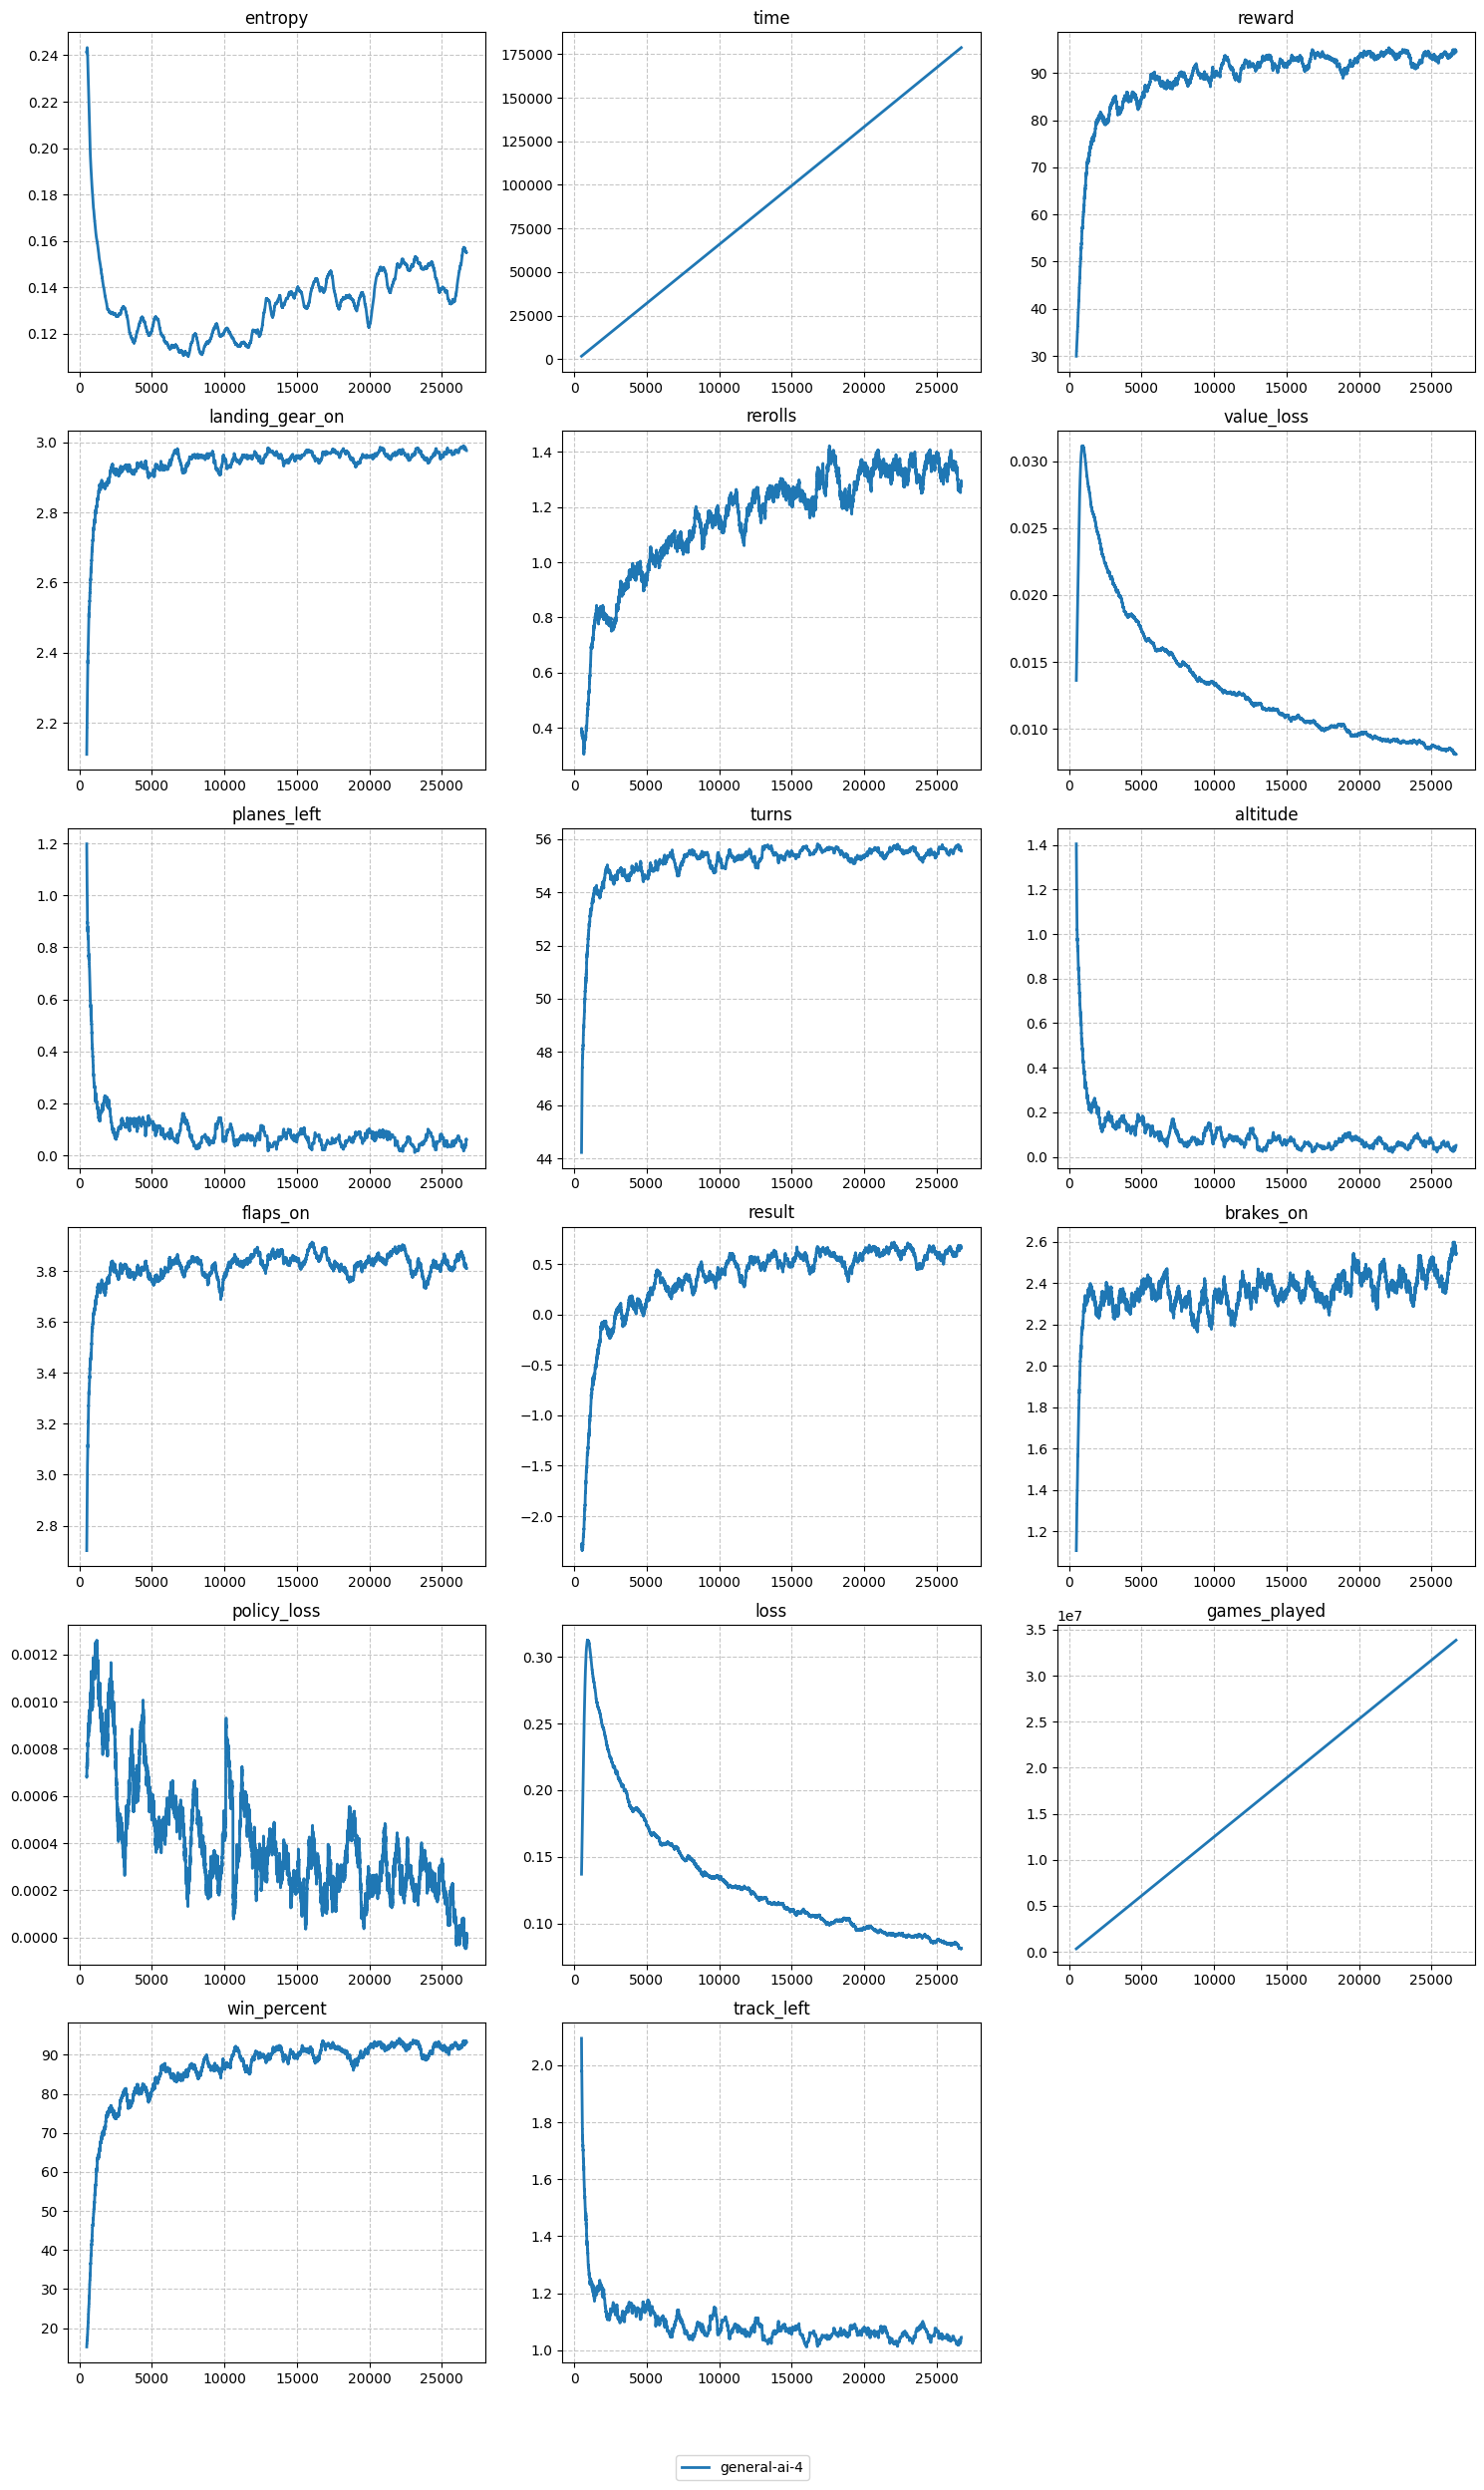

In [28]:
time_as_x_axis = False

fig, axes = plt.subplots(6, 3, figsize=(15, 25))
axes = axes.flatten()  # Flatten to make indexing easier

# Generate colors on-the-fly based on the number of models
model_names = list(data.keys())
color_palette = sns.color_palette("tab10", len(model_names))
colors = {model: color_palette[i] for i, model in enumerate(model_names)}

# Keep track of handles for the legend
legend_handles = []

# Plot each metric
all_metrics = set()
for model_name, model_data in data.items():
    all_metrics.update(model_data.keys())


for i, metric in enumerate(all_metrics):
    if i < len(axes):  # Ensure we don't go out of bounds
        ax = axes[i]

        for j, (model_name, model_data) in enumerate(data.items()):
            if metric in model_data:
                raw_data = np.array(model_data[metric])

                # Apply smoothing over previous 100 steps
                window_size = min(500, len(raw_data))
                if window_size > 0:
                    smoothed = np.convolve(raw_data, np.ones(window_size)/window_size, mode='valid')
                    offset = 0

                    if time_as_x_axis and 'time' in model_data:
                        x_values = model_data['time'][window_size-1:]
                    else:
                        x_values = np.arange(window_size-1, len(raw_data))

                    smooth_line, = ax.plot(x_values,
                                         smoothed + offset,
                                         linewidth=2, color=colors[model_name], linestyle='-',
                                         label=f'{model_name} (Smoothed)')

                    # Only add to legend handles once
                    if i == 0:
                        #legend_handles.append(raw_line)
                        legend_handles.append(smooth_line)

        ax.set_title(metric)
        ax.grid(True, linestyle='--', alpha=0.7)

# Hide any unused subplots
for j in range(len(all_metrics), len(axes)):
    axes[j].set_visible(False)

# Add a single shared legend at the bottom of the figure
fig.legend(handles=legend_handles,
           labels=[f'{model}' for model in model_names],
           loc='lower center', ncol=len(model_names), bbox_to_anchor=(0.5, 0))

plt.tight_layout()
plt.subplots_adjust(bottom=0.05)
plt.show()
